<a href="https://colab.research.google.com/github/xAn-x/VisionLab/blob/master/GoogleNet_(Inception_Net).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torchvision.datasets import CIFAR10

In [ ]:
MEAN,STD=(0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
transforms=T.Compose([
    T.ToTensor(),
    # T.Resize((224,224)),
    T.Normalize(MEAN,STD)  # Normalize with mean and std
])

train_ds=CIFAR10(root="./data",download=True,train=True,transform=transforms)
test_ds=CIFAR10(root="./data",download=False,train=False,transform=transforms)

Files already downloaded and verified


In [ ]:
labels=train_ds.class_to_idx

len(labels)

10

In [ ]:
from torch.utils.data import random_split

train_size=int(len(train_ds)*0.9)
val_size=len(train_ds)-train_size

train_ds,val_ds=random_split(train_ds,(train_size,val_size))

In [ ]:
print(f"Length of train ds: {len(train_ds)}")
print(f"Length of val ds: {len(val_ds)}")
print(f"Length of test ds: {len(test_ds)}")


Length of train ds: 45000
Length of val ds: 5000
Length of test ds: 10000


In [ ]:
train_dl=DataLoader(train_ds,batch_size=64,shuffle=True,pin_memory=True,num_workers=2)
val_dl=DataLoader(train_ds,batch_size=128,shuffle=False,pin_memory=True,num_workers=2)
test_dl=DataLoader(train_ds,batch_size=128,shuffle=False,pin_memory=True,num_workers=2)

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np

def denormalize(tensor, mean=MEAN, std=STD):
    mean = torch.tensor(mean).to(tensor.device).view(1, -1, 1, 1)
    std = torch.tensor(std).to(tensor.device).view(1, -1, 1, 1)

    denorm_tensor = tensor * std + mean
    return denorm_tensor

def visualize_batch(dataloader, mean=MEAN, std=STD):
    images, labels = next(iter(dataloader))
    denorm_images = denormalize(images, mean=mean, std=std)
    grid = make_grid(denorm_images)
    npimg = grid.numpy()
    plt.figure(figsize=(16,16))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

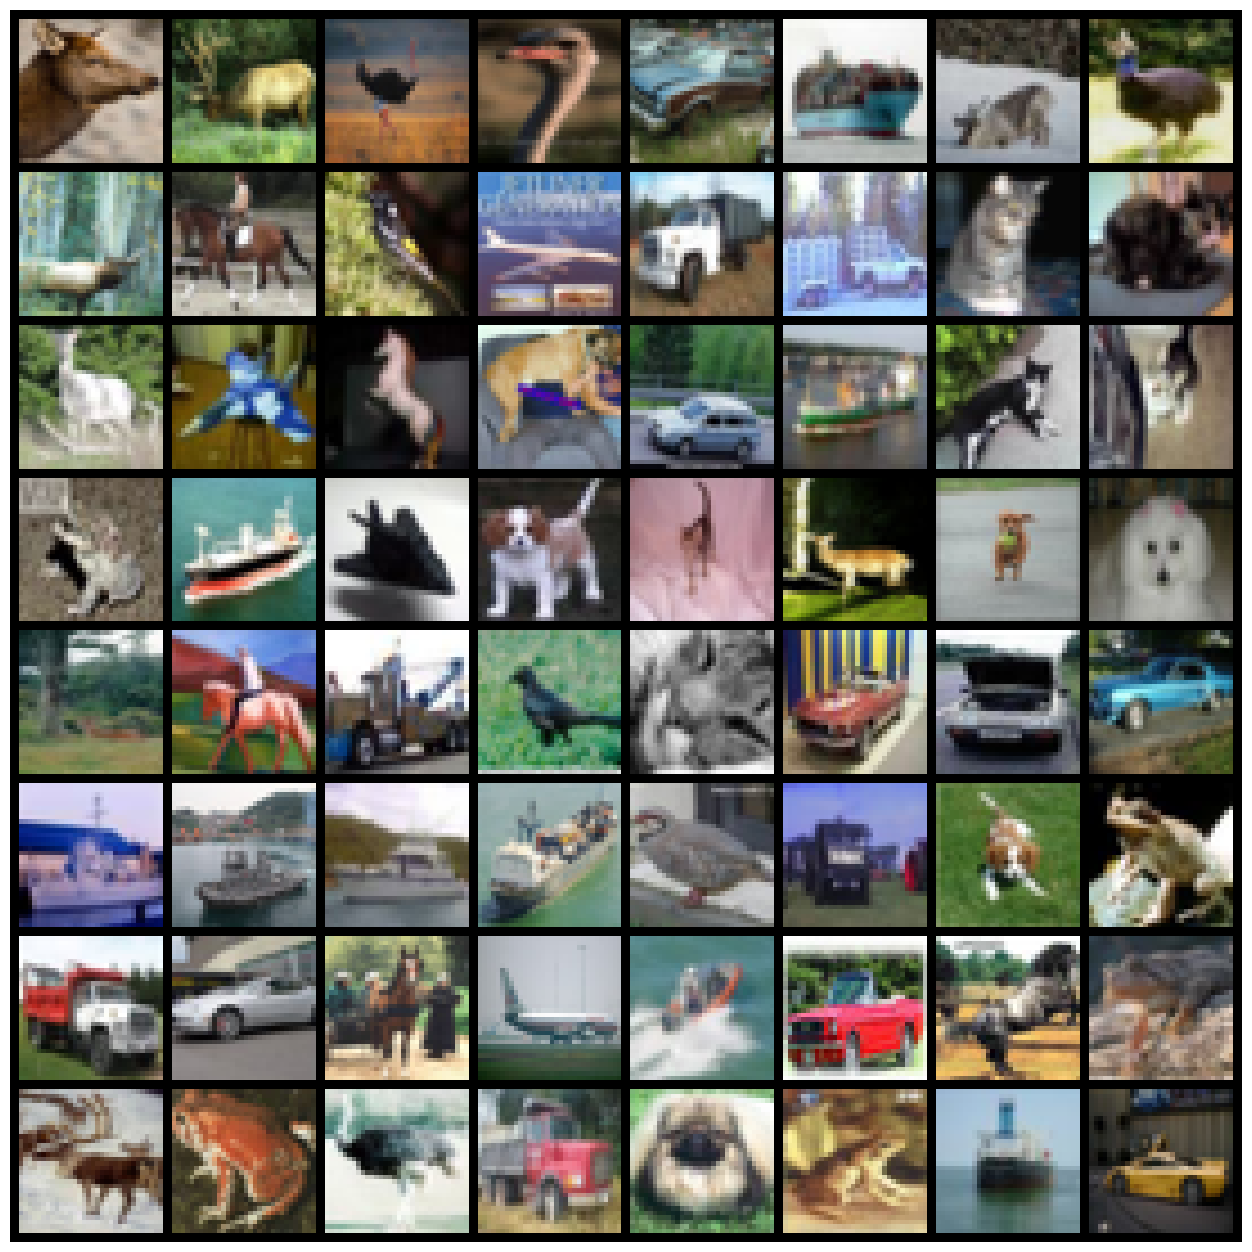

In [ ]:
visualize_batch(train_dl)

In [ ]:
# This is a helper block which do : conv->batch_norm->relu->output
class ConvBlock(nn.Module):
  def __init__(self,in_channels,out_channels,**kwargs):
    super(ConvBlock,self).__init__()

    self.conv=nn.Conv2d(in_channels,out_channels,**kwargs)
    self.batch_norm=nn.BatchNorm2d(out_channels)
    self.activation=nn.ReLU(inplace=True)

  def forward(self,x):
    return self.activation(self.batch_norm(self.conv(x)))

## `Inception Module`

## Original Problem

Salient parts in the image can have extremely large variation in size. For instance, an image with a cat can be either of the following, as shown below. The area occupied by the cat is different in each image.

* Because of this huge variation in the location of the information, choosing the right kernel size for the convolution operation becomes tough. A larger kernel is preferred for information that is distributed more globally, and a smaller kernel is preferred for information that is distributed more locally.

* Very deep networks are prone to overfitting. It also hard to pass gradient updates through the entire network.

* Naively stacking large convolution operations is computationally expensive.

## The Solution:

Why not have filters with multiple sizes operate on the same level? The network essentially would get a bit “wider” rather than “deeper”. The authors designed the inception module to reflect the same.

The below image is the “naive” inception module. It performs convolution on an input, with 3 different sizes of filters (1x1, 3x3, 5x5). Additionally, max pooling is also performed. The outputs are concatenated and sent to the next inception module.

Using the dimension reduced inception module, a neural network architecture was built. This was popularly known as GoogLeNet (Inception v1). The architecture is shown below:

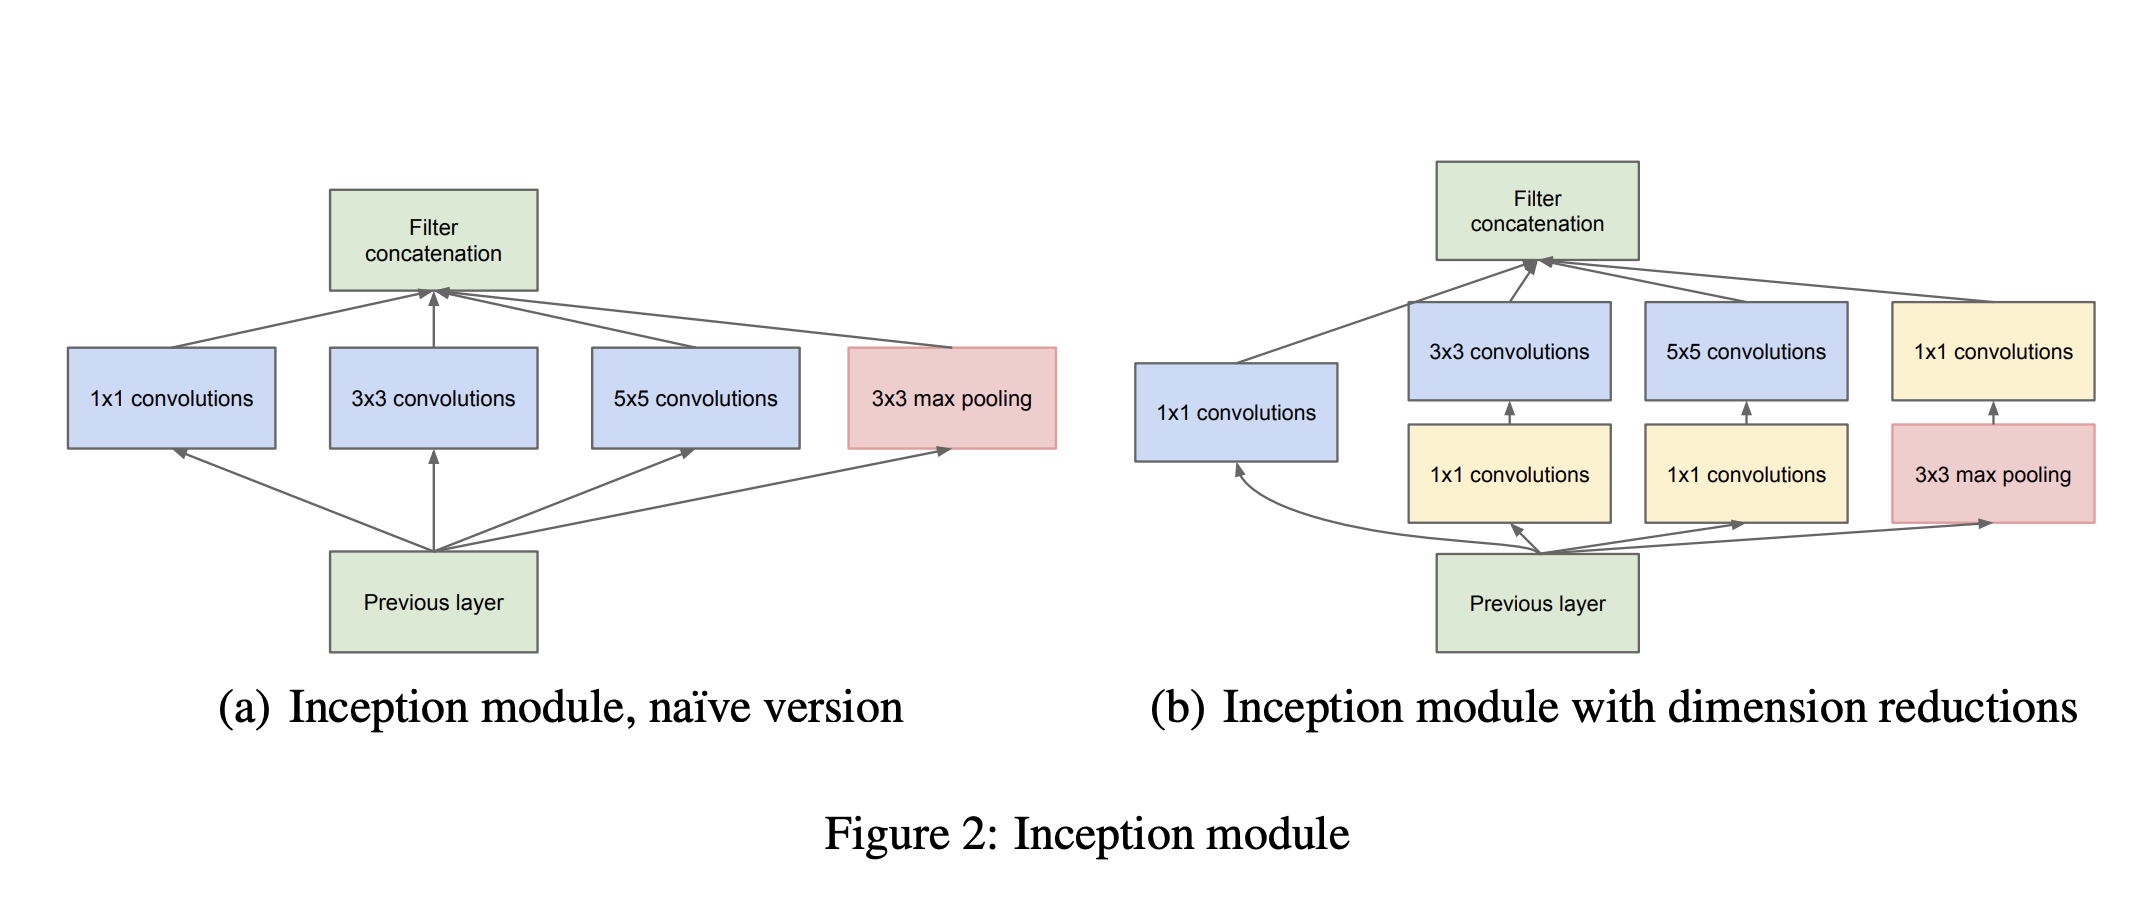

In [ ]:
# Inception Module test different kernel size to extract features both at local and global scale/lvl
class InceptionModule(nn.Module):
  def __init__(self,in_channels,num1x1,num3x3_reduce,num3x3,num5x5_reduce,num5x5,pool_proj):
    super(InceptionModule,self).__init__()

    self.branch0=nn.Sequential(
        ConvBlock(in_channels,num1x1,kernel_size=1,stride=1,padding=0)
    )

    self.branch1=nn.Sequential(
        ConvBlock(in_channels,num3x3_reduce,kernel_size=1,stride=1,padding=0),
        ConvBlock(num3x3_reduce,num3x3,kernel_size=3,stride=1,padding=1)
    )

    self.branch2=nn.Sequential(
        ConvBlock(in_channels,num5x5_reduce,kernel_size=1,stride=1,padding=0),
        ConvBlock(num5x5_reduce,num5x5,kernel_size=5,stride=1,padding=2)
    )

    self.branch3=nn.Sequential(
        nn.MaxPool2d(kernel_size=3,stride=1,padding=1,ceil_mode=True),
        ConvBlock(in_channels,pool_proj,kernel_size=1,stride=1,padding=0)
    )

  def forward(self,x):
    out0=self.branch0(x)
    out1=self.branch1(x)
    out2=self.branch2(x)
    out3=self.branch3(x)

    return torch.cat((out0,out1,out2,out3),dim=1)


## `GOOGLE (Inception) NET`
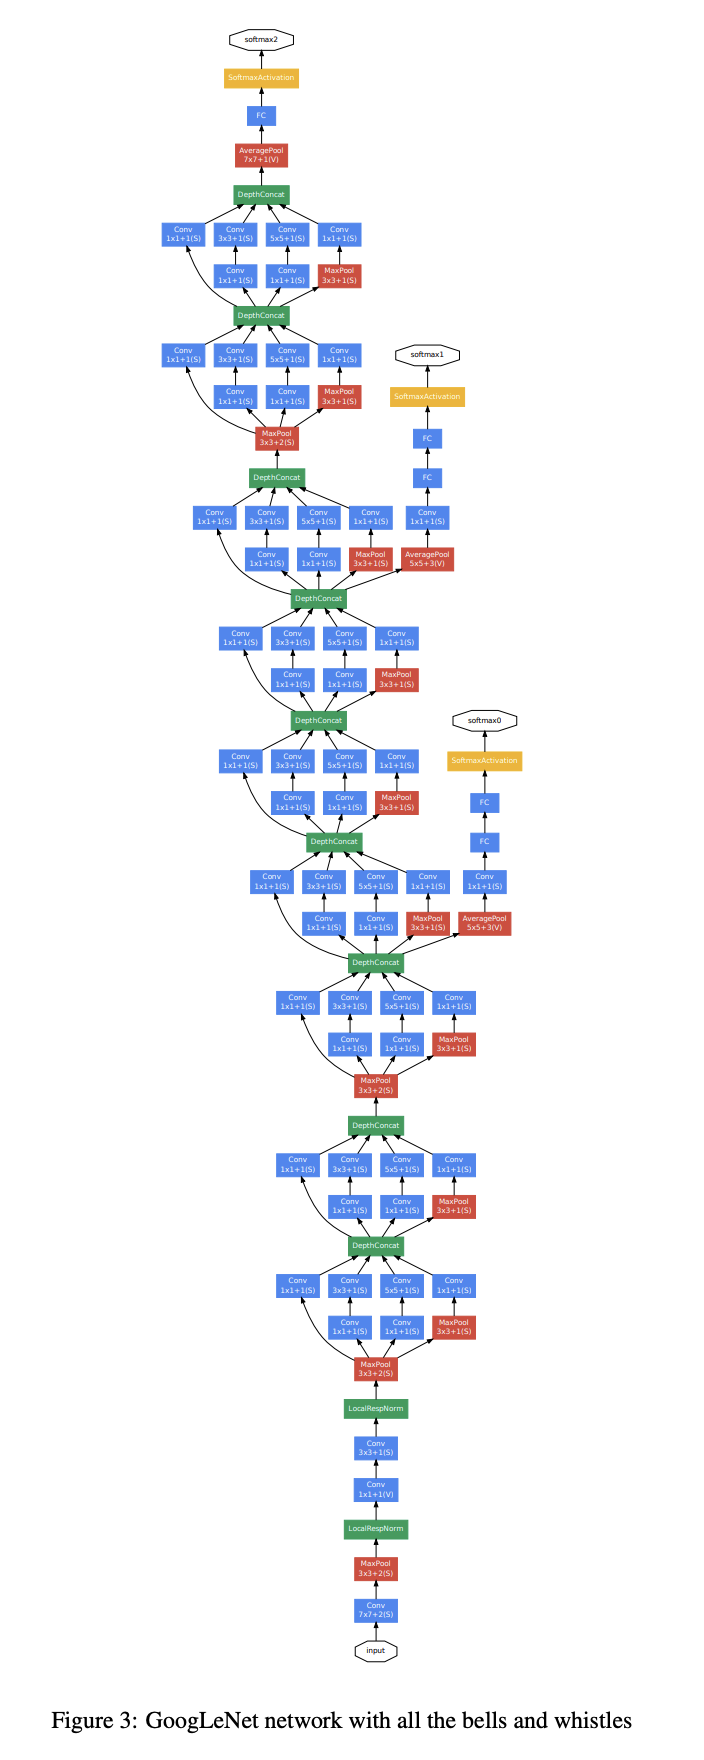

In [ ]:
# To make sure that our model learn usefull things as depth increase,AuxModule helps
class AuxilaryModule(nn.Module):
  def __init__(self,in_channels,num_classes):
    super(AuxilaryModule,self).__init__()

    self.pool=nn.AdaptiveAvgPool2d((4,4))
    self.conv=ConvBlock(in_channels,128,kernel_size=1,stride=1,padding=0)
    self.activation=nn.ReLU()
    self.lin1=nn.Linear(2048,1024)
    self.dropout=nn.Dropout(0.7) # 7-% dropout rate --> pretty high
    self.lin2=nn.Linear(1024,num_classes)

  def forward(self,x):
    out=self.pool(x)
    out=self.conv(out)
    out=self.activation(out)
    # print("out shape is ",out.shape)
    # out shape: (B,128,4,4)

    out=torch.flatten(out,start_dim=1)

    out=self.activation(self.lin1(out))
    out=self.dropout(out)
    out=self.lin2(out)

    return out

In [ ]:
# Architecture as mentioned in the paper
class GoogleNet(nn.Module):
  def __init__(self,in_channels,num_classes):
    super(GoogleNet,self).__init__()

    # stem-part
    self.conv1=ConvBlock(in_channels,64,kernel_size=7,stride=2,padding=3)
    self.pool1=nn.MaxPool2d(kernel_size=3,stride=2,padding=0,ceil_mode=True)
    self.conv2=ConvBlock(64,64,kernel_size=1,stride=1,padding=0)
    self.conv3=ConvBlock(64,192,kernel_size=3,stride=1,padding=1)
    self.pool2=nn.MaxPool2d(kernel_size=3,stride=2,padding=0,ceil_mode=True)

    # Inception 3a and 3b
    self.inception_3a=InceptionModule(192,num1x1=64,num3x3_reduce=96,num3x3=128,num5x5_reduce=16,num5x5=32,pool_proj=32)
    self.inception_3b=InceptionModule(256,num1x1=128,num3x3_reduce=128,num3x3=192,num5x5_reduce=32,num5x5=96,pool_proj=64)

    self.pool3=nn.MaxPool2d(kernel_size=3,stride=2,padding=0,ceil_mode=True)

     # Inception 4a,4b,4c,4d and 4e
    self.inception_4a=InceptionModule(480,num1x1=192,num3x3_reduce=96,num3x3=208,num5x5_reduce=16,num5x5=48,pool_proj=64)
    self.inception_4b=InceptionModule(512,num1x1=160,num3x3_reduce=112,num3x3=224,num5x5_reduce=24,num5x5=64,pool_proj=64)
    self.inception_4c=InceptionModule(512,num1x1=128,num3x3_reduce=128,num3x3=256,num5x5_reduce=24,num5x5=64,pool_proj=64)
    self.inception_4d=InceptionModule(512,num1x1=112,num3x3_reduce=144,num3x3=288,num5x5_reduce=32,num5x5=64,pool_proj=64)
    self.inception_4e=InceptionModule(528,num1x1=256,num3x3_reduce=160,num3x3=320,num5x5_reduce=32,num5x5=128,pool_proj=128)

    self.pool4=nn.MaxPool2d(kernel_size=3,stride=2,padding=0,ceil_mode=True)

    # Auxiallary_4a and Auxiallary_4d
    self.aux_4a=AuxilaryModule(480,num_classes)
    self.aux_4d=AuxilaryModule(512,num_classes)

    # Inception 5a and 5b
    self.inception_5a=InceptionModule(832,num1x1=256,num3x3_reduce=160,num3x3=320,num5x5_reduce=32,num5x5=128,pool_proj=128)
    self.inception_5b=InceptionModule(832,num1x1=384,num3x3_reduce=192,num3x3=384,num5x5_reduce=48,num5x5=128,pool_proj=128)

    self.pool5=nn.AdaptiveAvgPool2d((1,1))

    self.dropout=nn.Dropout(0.4)
    self.linear=nn.Linear(1024,num_classes)


  def forward(self,x):
    out=self.conv1(x)
    out=self.pool1(out)
    out=self.conv2(out)
    out=self.conv3(out)
    out=self.pool2(out)
    out=self.inception_3a(out)
    out=self.inception_3b(out)
    out=self.pool3(out)

    out_aux_4a=self.aux_4a(out)
    out=self.inception_4a(out)

    out=self.inception_4b(out)
    out=self.inception_4c(out)

    out_aux_4d=self.aux_4d(out)
    out=self.inception_4d(out)

    out=self.inception_4e(out)
    out=self.pool4(out)

    out=self.inception_5a(out)
    out=self.inception_5b(out)
    out=self.pool5(out)

    out=torch.flatten(out,start_dim=1)
    out=self.dropout(out)
    out=self.linear(out)

    # As mentioned in paper while traing we use 30% of auxillary outputs for pred but durin test we don't use auxillary out
    # auxillary output make sure that even in such a deep cnn our model should learn something usefull
    return out,out_aux_4a,out_aux_4d

In [ ]:
DEVICE=torch.device("cuda" if torch.cuda.is_available() else "cpu")

DEVICE

'cuda'

In [ ]:
model=GoogleNet(3,10).to(DEVICE)

model

GoogleNet(
  (conv1): ConvBlock(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): ConvBlock(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU(inplace=True)
  )
  (conv3): ConvBlock(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batch_norm): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception_3a): InceptionModule(
    (branch0): Sequential(
      (0): ConvBlock(
        (conv): Conv2d(192, 64, k

In [ ]:
from torchsummary import summary
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,472
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         ConvBlock-4           [-1, 64, 16, 16]               0
         MaxPool2d-5             [-1, 64, 8, 8]               0
            Conv2d-6             [-1, 64, 8, 8]           4,160
       BatchNorm2d-7             [-1, 64, 8, 8]             128
              ReLU-8             [-1, 64, 8, 8]               0
         ConvBlock-9             [-1, 64, 8, 8]               0
           Conv2d-10            [-1, 192, 8, 8]         110,784
      BatchNorm2d-11            [-1, 192, 8, 8]             384
             ReLU-12            [-1, 192, 8, 8]               0
        ConvBlock-13            [-1, 192, 8, 8]               0
        MaxPool2d-14            [-1, 19

In [ ]:
import numpy as np

def train_model(model, train_dataloader, val_dataloader, epochs, device, optimizer, criterion):
    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []

    for epoch in range(epochs):
        model.train()
        total_correct_train = 0
        total_train_samples = 0
        total_train_loss = 0.0

        for batch in train_dataloader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            final_out, aux4a_out, aux4d_out = model(images)

            # Calculate individual losses
            final_loss = criterion(final_out, labels)
            aux4a_loss = criterion(aux4a_out, labels)
            aux4d_loss = criterion(aux4d_out, labels)

            loss = final_loss + 0.3 * aux4a_loss + 0.3 * aux4d_loss
            loss = loss.mean()  # Take mean over the batch dimension

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

            _, predicted = torch.max(final_out, 1)
            total_correct_train += (predicted == labels).sum().item()
            total_train_samples += labels.size(0)

        train_loss.append(total_train_loss / len(train_dataloader))
        train_accuracy.append(total_correct_train / total_train_samples)

        # Calculate validation accuracy after each epoch
        model.eval()
        with torch.no_grad():
            total_correct_val = 0
            total_val_samples = 0
            total_val_loss = 0.0
            for batch in val_dataloader:
                images, labels = batch
                images, labels = images.to(device), labels.to(device)

                final_out, aux4a_out, aux4d_out = model(images)

                # Calculate individual losses
                final_loss = criterion(final_out, labels)
                aux4a_loss = criterion(aux4a_out, labels)
                aux4d_loss = criterion(aux4d_out, labels)

                loss = final_loss + 0.3 * aux4a_loss + 0.3 * aux4d_loss
                loss = loss.mean()  # Take mean over the batch dimension

                total_val_loss += loss.item()

                _, predicted = torch.max(final_out, 1)
                total_correct_val += (predicted == labels).sum().item()
                total_val_samples += labels.size(0)

            val_loss.append(total_val_loss / len(val_dataloader))
            val_accuracy.append(total_correct_val / total_val_samples)

        print(f"Epoch: {epoch + 1}")
        print(f"Training Loss: {train_loss[-1]:.4f}")
        print(f"Training Accuracy: {train_accuracy[-1]:.4f}")
        print(f"Validation Loss: {val_loss[-1]:.4f}")
        print(f"Validation Accuracy: {val_accuracy[-1]:.4f}\n")

    return {
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_accuracy": train_accuracy,
        "val_accuracy": val_accuracy
    }

In [ ]:
# Define optimizer and criterion
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = F.cross_entropy

# Assuming 'device' is defined earlier
# Train the model
hist = train_model(model, train_dl, val_dl, epochs=15, device=DEVICE, optimizer=optimizer, criterion=criterion)

Epoch: 1
Training Loss: 2.4311
Training Accuracy: 0.4503
Validation Loss: 2.1726
Validation Accuracy: 0.5202

Epoch: 2
Training Loss: 1.7989
Training Accuracy: 0.6133
Validation Loss: 1.6385
Validation Accuracy: 0.6321

Epoch: 3
Training Loss: 1.5190
Training Accuracy: 0.6794
Validation Loss: 1.3364
Validation Accuracy: 0.7150

Epoch: 4
Training Loss: 1.2955
Training Accuracy: 0.7302
Validation Loss: 0.9589
Validation Accuracy: 0.7934

Epoch: 5
Training Loss: 1.1162
Training Accuracy: 0.7691
Validation Loss: 0.8465
Validation Accuracy: 0.8177

Epoch: 6
Training Loss: 0.9906
Training Accuracy: 0.7955
Validation Loss: 0.6949
Validation Accuracy: 0.8512

Epoch: 7
Training Loss: 0.8698
Training Accuracy: 0.8190
Validation Loss: 0.8049
Validation Accuracy: 0.8260

Epoch: 8
Training Loss: 0.7857
Training Accuracy: 0.8378
Validation Loss: 0.6471
Validation Accuracy: 0.8572

Epoch: 9
Training Loss: 0.7105
Training Accuracy: 0.8532
Validation Loss: 0.4904
Validation Accuracy: 0.8962

Epoch: 10


In [ ]:
def visualize_metric(hist,metric):
  plt.plot(hist[f"train_{metric}"],"r*--",label=f"train_{metric}")
  plt.plot(hist[f"val_{metric}"],"b*--",label=f"val_{metric}")
  plt.legend()

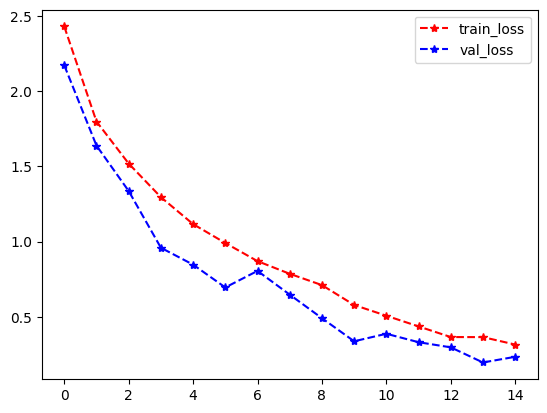

In [ ]:
visualize_metric(hist,"loss")

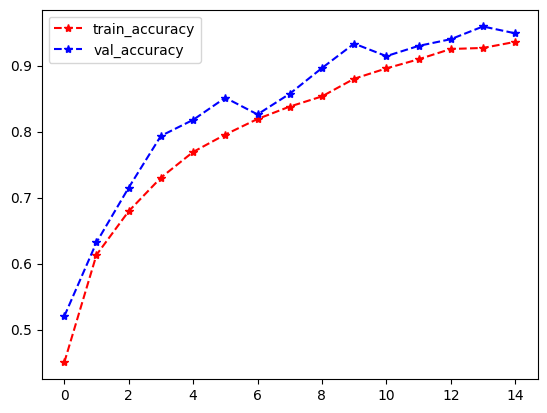

In [ ]:
visualize_metric(hist,"accuracy")

In [ ]:
@torch.no_grad()
def get_test_res(model,test_dl,device):
  total_correct=0
  total_samples=0
  for batch in test_dl:
    images,labels=batch
    images,labels=images.to(device),labels.to(device)

    final_logits, _ , _ = model(images)

    probs=F.softmax(final_logits,dim=1)

    _,preds=torch.max(probs,dim=1)

    total_correct += (preds == labels).sum().item()
    total_samples += labels.numel()

  print(f"{total_correct}/{total_samples}")
  print(f"Accuracy: {(total_correct/total_samples):.4f}%")

In [ ]:
get_test_res(model,test_dl,DEVICE)

42695/45000
Accuracy: 0.9488%


### `The model can be runned for few more epochs as there r no signs of overfitting or something but it is taking a lot of time 😅`